# Reading AIRS files

The Atmospheric Infrared Sounder (AIRS) is a grating spectrometer (R = 1200) aboard the second Earth Observing System (EOS) polar-orbiting platform, EOS Aqua. In combination with the Advanced Microwave Sounding Unit (AMSU) and the Humidity Sounder for Brazil (HSB), AIRS constitutes an innovative atmospheric sounding group of visible, infrared, and microwave sensors. The VIS/NIR level 1B data set contains visible and near-infrared calibrated and geolocated radiances in W/m^2/micron/steradian. This data set includes 4 channels in the 0.4 to 1.0 um region of the spectrum. Each day of AIRS data are divided into 240 granules each of 6 minute duration. However, the VIS/NIR granules are only produced in the daytime so there will always be fewer VIS/NIR granules. The primary purpose of the VIS/NIR channels is the detection and flagging of significant inhomogeneities in the infrared field-of-view,which may adversely impact the quality of the temperature and moisture soundings. Therefore the VIS/NIR radiance product has a higher spatial resolution than the Infrared radiance product. Each VIS/NIR scan has 9 alongtrack footprints and 720 across track footprints. For ease in comparing with the infrared product which has 135 along track footprints and 90 across track footprints, the VIS/NIR product has additional dimensions to account for the 9 additional alongtrack and 8 additional across track footprints.

https://disc.gsfc.nasa.gov/datasets/AIRVBRAD_005/summary?keywords=%22AIRS%22

The official readme is quite old, and is here: 
https://docserver.gesdisc.eosdis.nasa.gov/repository/Mission/AIRS/3.3_ScienceDataProductDocumentation/3.3.4_ProductGenerationAlgorithms/README.AIRVBRAD.pdf

## Final demonstration

In [1]:
from hdf_functions import *

In [2]:
# ftest = hdf_to_netcdf('CAL_LID_L3_Cloud_Occurrence-Standard-V1-00.2009-06A.hdf')

## Development of functions

In [65]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# from mpl_toolkits.basemap import Basemap # use cartopy now
import cartopy as cpy
import cartopy.crs as ccrs

from matplotlib import colors
from pyhdf.SD import SD, SDC

import xarray as xr
import pandas as pd

import cartopy.feature as cfeature


In [3]:
# # Import packages
# import os
# import re  # regular expressions
# import warnings
# import matplotlib.pyplot as plt
# import numpy as np
# import numpy.ma as ma
# import rasterio as rio
# from rasterio.plot import plotting_extent
# import geopandas as gpd
# import earthpy as et
# import earthpy.plot as ep
# import earthpy.spatial as es
# import earthpy.mask as em

In [3]:
obs_dir = '/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/single_obs/'
airs_file = 'AIRS.2021.06.07.098.L1B.VIS_Rad.v5.0.0.0.G21158152755.hdf'

#### Load a single AIRS calibrated radiance file

135 across-track scans ('GeoTrack:L1B_VIS_Science')

9 AIRS footprints per AMSU footprint (3x3) ('SubTrack:L1B_VIS_Science')

90 AIRS footprints in a scan ('GeoXTrack:L1B_VIS_Science')

8 AIRS obtains eight cross-track samples of each Vis/NIR detector ('SubXTrack:L1B_VIS_Science')

4 NIR/VIS channels

So each granule is a (135 * 9) x (90 * 8) pixel image. (1215x720)

In [6]:
hdf = SD('%s/%s' % (obs_dir,airs_file), SDC.READ)

In [10]:
hdf.datasets()['Latitude'][:]

(('GeoTrack:L1B_VIS_Science', 'GeoXTrack:L1B_VIS_Science'), (135, 90), 6, 0)

In [30]:
# Read dataset.
# DATAFIELD_NAME = 'Latitude'
lats = hdf.select('Latitude')
lons = hdf.select('Longitude')

rads = hdf.select('radiances')
# data = data2D[:,0]

In [31]:
rads.dimensions()

{'GeoTrack:L1B_VIS_Science': 135,
 'GeoXTrack:L1B_VIS_Science': 90,
 'Channel:L1B_VIS_Science': 4,
 'SubTrack:L1B_VIS_Science': 9,
 'SubXTrack:L1B_VIS_Science': 8}

In [33]:
rads[:].shape

(135, 90, 4, 9, 8)

In [36]:
oop = rads[:]

In [44]:
oop.mean(axis=(3,4)).shape

(135, 90, 4)

Average over the subtracks (for now)

In [45]:
rads_sub = rads[:].mean(axis=(3,4))

In [47]:
rads_sub.shape

(135, 90, 4)

In [28]:
lats.dimensions()

{'GeoTrack:L1B_VIS_Science': 135, 'GeoXTrack:L1B_VIS_Science': 90}

In [29]:
lons.dimensions()

{'GeoTrack:L1B_VIS_Science': 135, 'GeoXTrack:L1B_VIS_Science': 90}

In [59]:
np.min(lats)

-49.74696490136495

In [60]:
np.max(lats)

-25.639697193078877

In [24]:
data2D[:].flat

In [57]:
hdf.select('cornerlats')[:].shape

(135, 90, 4, 4)

In [58]:
hdf.select('cornerlons')[:].shape

(135, 90, 4, 4)

In [49]:
WASHINGTON_NORTH = 2926
WASHINGTON_SOUTH = 2927
SEATTLE_BOUNDS = [-122.4596959,-122.2244331,47.4919119,47.734145]
WASHINGTON_BOUNDS = [-124.849,-116.9156,45.5435,49.0024]
SEATTLE_CENTER = (-122.3321, 47.6062)

In [71]:
bnds = [np.min(lons)-1,np.max(lons)+1,np.min(lats)-1,np.max(lats)+1]

In [72]:
bnds

[49.756031710139574,
 78.79729929787841,
 -50.74696490136495,
 -24.639697193078877]

In [82]:
def stack_rgb(reflArray):
    '''
    Modified from: 
    https://www.neonscience.org/resources/learning-hub/tutorials/neon-hsi-aop-functions-tiles-py
    '''

    red = reflArray[:,:,0]
    green = reflArray[:,:,1]
    blue = reflArray[:,:,2]

    stackedRGB = np.stack((red,green,blue),axis=2)

    return stackedRGB

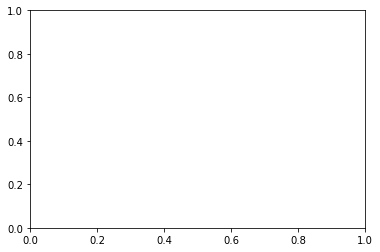

In [89]:
def plot_aop_refl(band_array,refl_extent,colorlimit=(0,1),ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='Greys'):

    '''plot_refl_data reads in and plots a single band or 3 stacked bands of a reflectance array
    --------
    Parameters
    --------
        band_array: array of reflectance values, created from aop_h5refl2array
        refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) 
                     use metadata['spatial extent'] from aop_h5refl2array function
        colorlimit: optional, range of values to plot (min,max). 
                    - helpful to look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: optional; plot title (string)
        cmap_title: optional; colorbar title 
        colormap: optional (string, see https://matplotlib.org/examples/color/colormaps_reference.html) for list of colormaps
    --------
    Returns 
    --------
        plots flightline array of single band of reflectance data
    --------

    Examples:
    --------
    plot_aop_refl(sercb56,
              sercMetadata['spatial extent'],
              colorlimit=(0,0.3),
              title='SERC Band 56 Reflectance',
              cmap_title='Reflectance',
              colormap='Greys_r') '''

    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation for ticklabels
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

In [95]:
# plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
ax.imshow(test,extent=bnds)#,clim=colorlimit); 
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [83]:
test = stack_rgb(rads_sub)

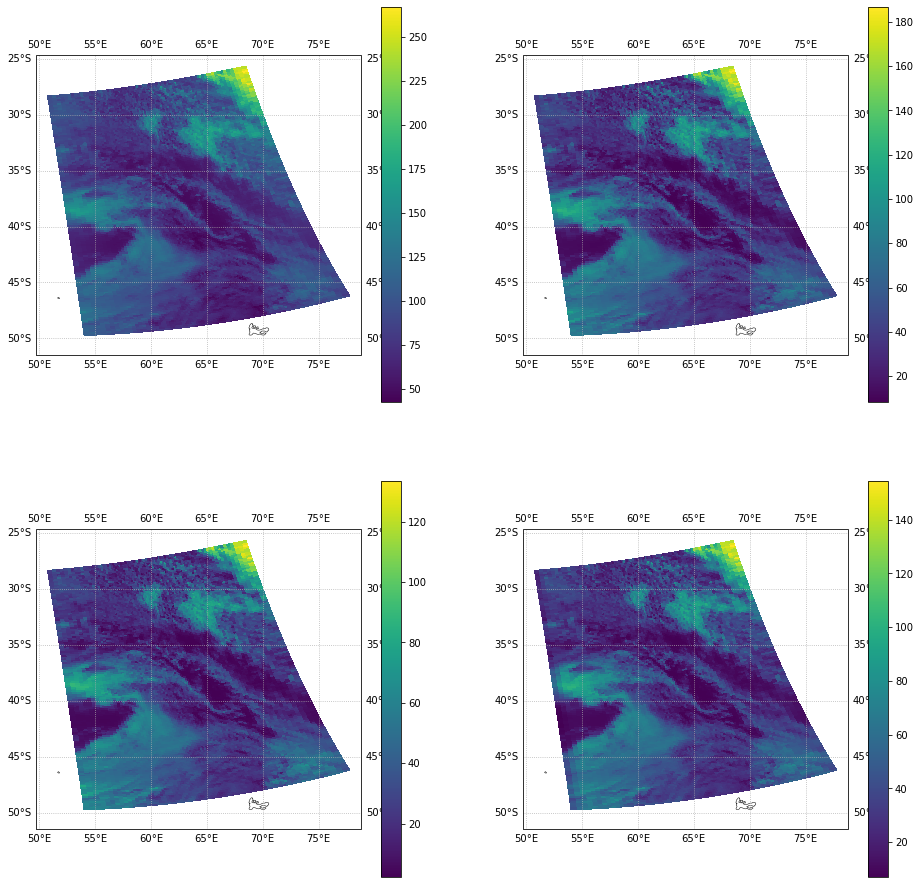

In [111]:
fig,axes = plt.subplots(2,2,figsize=(16, 16),subplot_kw={'projection':ccrs.PlateCarree()})
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.Mercator())
# ax = plt.axes(projection=_DEFAULT_PROJECTION)
# ax.set_title("Washington – Web Mercator Reference (epsg:3857)")
# ax.annotate('Seattle', xy=SEATTLE_CENTER, xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), color='red',
#             ha='left', va='center')
# ax.add_feature(states_feature)

for i,ax in enumerate(axes.flat):
    
    im = ax.pcolor(lons, lats, rads_sub[:,:,i],
             transform=ccrs.PlateCarree(),clim=(0,200))
    
    ax.set_extent(bnds) # not setting bounds means we can see the full extent of the projected space.
    gl = ax.gridlines(linestyle=":", draw_labels=True)

    ax.add_feature(cfeature.COASTLINE, linewidth=0.5);
    ax.add_feature(cfeature.BORDERS, linewidth=0.5);
# ax.tissot(lats=range(43, 51), lons=range(-124, -116), alpha=0.4, rad_km=20000, color='orange')

    plt.colorbar(im,ax=ax)
# plt.plot2d(lats,lons,rads_sub[0],ax=ax)

/glade/work/jonahshaw/miniconda3/envs/hdfer/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


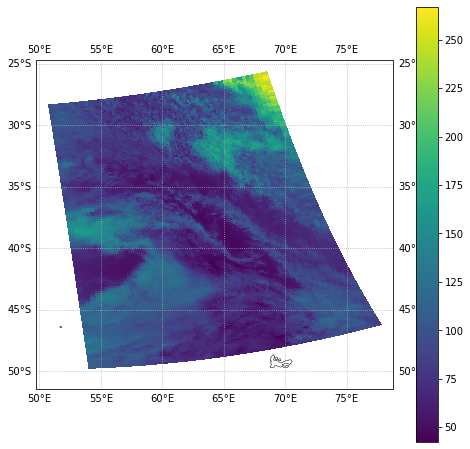

In [103]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.Mercator())
# ax = plt.axes(projection=_DEFAULT_PROJECTION)
ax.set_extent(bnds) # not setting bounds means we can see the full extent of the projected space.
# ax.set_title("Washington – Web Mercator Reference (epsg:3857)")
# ax.annotate('Seattle', xy=SEATTLE_CENTER, xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), color='red',
#             ha='left', va='center')
# ax.add_feature(states_feature)
gl = ax.gridlines(linestyle=":", draw_labels=True)

ax.add_feature(cfeature.COASTLINE, linewidth=0.5);
ax.add_feature(cfeature.BORDERS, linewidth=0.5);
# ax.tissot(lats=range(43, 51), lons=range(-124, -116), alpha=0.4, rad_km=20000, color='orange')


im = plt.pcolor(lons, lats, rads_sub[:,:,0],
             transform=ccrs.PlateCarree())

plt.colorbar(im)
# plt.plot2d(lats,lons,rads_sub[0],ax=ax)

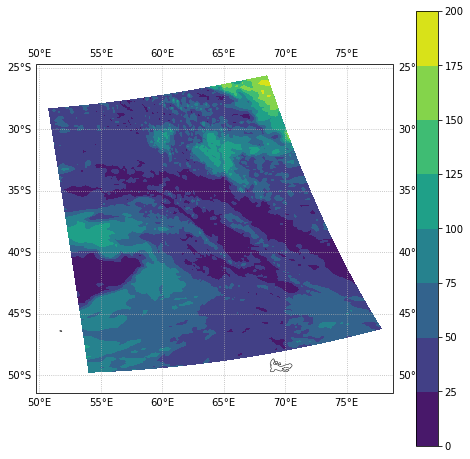

In [98]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.Mercator())
# ax = plt.axes(projection=_DEFAULT_PROJECTION)
ax.set_extent(bnds) # not setting bounds means we can see the full extent of the projected space.
# ax.set_title("Washington – Web Mercator Reference (epsg:3857)")
# ax.annotate('Seattle', xy=SEATTLE_CENTER, xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), color='red',
#             ha='left', va='center')
# ax.add_feature(states_feature)
gl = ax.gridlines(linestyle=":", draw_labels=True)

ax.add_feature(cfeature.COASTLINE, linewidth=0.5);
ax.add_feature(cfeature.BORDERS, linewidth=0.5);
# ax.tissot(lats=range(43, 51), lons=range(-124, -116), alpha=0.4, rad_km=20000, color='orange')


im = plt.contourf(lons, lats, rads_sub[:,:,1],
             transform=ccrs.PlateCarree())
# plt.plot2d(lats,lons,rads_sub[0],ax=ax)
plt.colorbar(im)


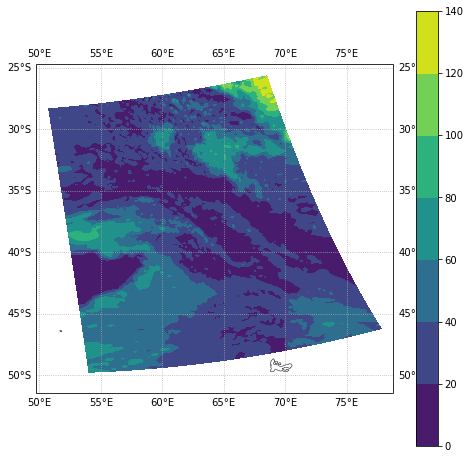

In [99]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.Mercator())
# ax = plt.axes(projection=_DEFAULT_PROJECTION)
ax.set_extent(bnds) # not setting bounds means we can see the full extent of the projected space.
# ax.set_title("Washington – Web Mercator Reference (epsg:3857)")
# ax.annotate('Seattle', xy=SEATTLE_CENTER, xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), color='red',
#             ha='left', va='center')
# ax.add_feature(states_feature)
gl = ax.gridlines(linestyle=":", draw_labels=True)
# ax.tissot(lats=range(43, 51), lons=range(-124, -116), alpha=0.4, rad_km=20000, color='orange')


im = plt.contourf(lons, lats, rads_sub[:,:,2],
             transform=ccrs.PlateCarree())

plt.colorbar(im)

ax.add_feature(cfeature.COASTLINE, linewidth=0.5);
ax.add_feature(cfeature.BORDERS, linewidth=0.5);
# plt.plot2d(lats,lons,rads_sub[0],ax=ax)

In [17]:
hdf.datasets().keys()

dict_keys(['Latitude', 'Longitude', 'Time', 'radiances', 'offset', 'offset_err', 'NeN', 'PrelimCldQA', 'PrelimCldFracVis', 'PrelimCldFracVisErr', 'PrelimClrFracVis', 'PrelimClrFracVisErr', 'PrelimCldMapVis', 'PrelimNDVI', 'bright_index', 'inhomo_index', 'scanang', 'ftptgeoqa', 'zengeoqa', 'demgeoqa', 'satzen', 'satazi', 'solzen', 'solazi', 'sun_glint_distance', 'topog', 'topog_err', 'landFrac', 'landFrac_err', 'limit_scene_counts.red_lo_limit', 'limit_scene_counts.red_lo_cnt', 'limit_scene_counts.to_red_lo', 'limit_scene_counts.yellow_lo_limit', 'limit_scene_counts.yellow_lo_cnt', 'limit_scene_counts.to_yellow_lo', 'limit_scene_counts.green_cnt', 'limit_scene_counts.to_green', 'limit_scene_counts.yellow_hi_limit', 'limit_scene_counts.yellow_hi_cnt', 'limit_scene_counts.to_yellow_hi', 'limit_scene_counts.red_hi_limit', 'limit_scene_counts.red_hi_cnt', 'limit_scene_counts.to_red_hi', 'limit_scene_counts.missing', 'limit_bb_counts.red_lo_limit', 'limit_bb_counts.red_lo_cnt', 'limit_bb_cou

In [29]:
hdf.info()

(184, 3)

In [14]:
# List available SDS datasets.
print(hdf.datasets().keys())

dict_keys(['Latitude', 'Longitude', 'Time', 'radiances', 'offset', 'offset_err', 'NeN', 'PrelimCldQA', 'PrelimCldFracVis', 'PrelimCldFracVisErr', 'PrelimClrFracVis', 'PrelimClrFracVisErr', 'PrelimCldMapVis', 'PrelimNDVI', 'bright_index', 'inhomo_index', 'scanang', 'ftptgeoqa', 'zengeoqa', 'demgeoqa', 'satzen', 'satazi', 'solzen', 'solazi', 'sun_glint_distance', 'topog', 'topog_err', 'landFrac', 'landFrac_err', 'limit_scene_counts.red_lo_limit', 'limit_scene_counts.red_lo_cnt', 'limit_scene_counts.to_red_lo', 'limit_scene_counts.yellow_lo_limit', 'limit_scene_counts.yellow_lo_cnt', 'limit_scene_counts.to_yellow_lo', 'limit_scene_counts.green_cnt', 'limit_scene_counts.to_green', 'limit_scene_counts.yellow_hi_limit', 'limit_scene_counts.yellow_hi_cnt', 'limit_scene_counts.to_yellow_hi', 'limit_scene_counts.red_hi_limit', 'limit_scene_counts.red_hi_cnt', 'limit_scene_counts.to_red_hi', 'limit_scene_counts.missing', 'limit_bb_counts.red_lo_limit', 'limit_bb_counts.red_lo_cnt', 'limit_bb_cou

In [25]:
hdf.attr('Latitude')

In [16]:
# Read dataset.
DATAFIELD_NAME = 'radiances'
data2D = hdf.select(DATAFIELD_NAME)
# data = data2D[:,0]

In [34]:
# Read dataset.
data3D = hdf.select(DATAFIELD_NAME)
data = data3D[0,:,:]

# Read geolocation dataset.
lat = hdf.select('Latitude')
latitude = lat[:,:]
lon = hdf.select('Longitude')
longitude = lon[:,:]

# Handle fill value.
attrs = data3D.attributes(full=1)
fillvalue=attrs["_FillValue"]

# fillvalue[0] is the attribute value.
fv = fillvalue[0]
data[data == fv] = np.nan
data = np.ma.masked_array(data, np.isnan(data))

In [43]:
longitude.shape

(135, 90)

In [45]:
data.shape

(90, 4, 9, 8)

In [39]:
m = cpy(projection='cyl', resolution='l',
            llcrnrlat=-90, urcrnrlat = 90,
            llcrnrlon=-180, urcrnrlon = 180)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])
m.pcolormesh(longitude, latitude, data, latlon=True, alpha=0.90)

TypeError: 'module' object is not callable

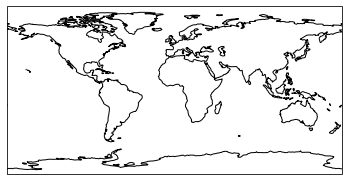

In [41]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

What are all of these dimensions?

In [28]:
data2D[:].shape

(135, 90, 4, 9, 8)

In [4]:
username = 'jshaw35'
password = 'Sh1tmusic!earthdata'
url = 'https://asdc.larc.nasa.gov/data/CALIPSO/LID_L3_Cloud_Occurrence-Standard-V1-00/2009/CAL_LID_L3_Cloud_Occurrence-Standard-V1-00.2009-03A.hdf'

In [5]:
filename = 'CAL_LID_L3_Cloud_Occurrence-Standard-V1-00.2009-03A.hdf'

### Not sure if this is working

In [9]:
from requests import Session
session = Session()
session.auth = (username, password)
_redirect = session.get(url)
_response = session.get(_redirect.url)
with open(file_name, 'wb') as file:
    file.write(_response._content)


KeyboardInterrupt: 

In [4]:
ls

CAL_LID_L3_Cloud_Occurrence-Standard-V1-00.2009-06A.hdf
file_testing.ipynb


In [5]:
DATAFIELD_NAME = 'Cloud_Accepted_Samples'
FILE_NAME = 'CAL_LID_L3_Cloud_Occurrence-Standard-V1-00.2009-06A.hdf'
hdf = SD(FILE_NAME, SDC.READ)

In [6]:
hdf.attr('CAL_LID_L3_Cloud_Occurrence')

In [7]:
# Read dataset.
DATAFIELD_NAME = 'Temperature_Mean'
data2D = hdf.select(DATAFIELD_NAME)
data = data2D[:,0]

In [8]:
hdf.info()

(35, 1)

In [9]:
# Potentially relevant datasets:
# Longitude_Midpoint
# Latitude_Midpoint
# Altitude_Midpoint
# Pressure_Mean
# Pressure_Standard_Deviation
# Temperature_Mean
# Temperature_Standard_Deviation
# Days_Of_Month_Observed 'latitude', 'longitude'
# 'Cloud_Free_Samples',
#  'Cloud_Samples',
#  'Cloud_Rejected_Samples',
#  'Cloud_Accepted_Samples',
#  'Unknown_Cloud_Transparent_Samples',
#  'Unknown_Cloud_Opaque_Samples',
#  'Water_Cloud_Transparent_Samples',
#  'Water_Cloud_Opaque_Samples',
#  'Ice_Cloud_Transparent_Samples',
#  'Ice_Cloud_Opaque_Samples',

Cloud fraction apparently is:  

cloud_accepted_samples / (cloud_accepted_samples + cloud_rejected_samples + cloud_free_samples)

In [40]:
hdf.datasets()

{'Longitude_Midpoint': (('longitude',), (144,), 5, 0),
 'Latitude_Midpoint': (('latitude',), (85,), 5, 1),
 'Altitude_Midpoint': (('altitude',), (344,), 5, 2),
 'Pressure_Mean': (('latitude', 'longitude', 'altitude'),
  (85, 144, 344),
  5,
  3),
 'Pressure_Standard_Deviation': (('latitude', 'longitude', 'altitude'),
  (85, 144, 344),
  5,
  4),
 'Temperature_Mean': (('latitude', 'longitude', 'altitude'),
  (85, 144, 344),
  5,
  5),
 'Temperature_Standard_Deviation': (('latitude', 'longitude', 'altitude'),
  (85, 144, 344),
  5,
  6),
 'Relative_Humidity_Mean': (('latitude', 'longitude', 'altitude'),
  (85, 144, 344),
  5,
  7),
 'Relative_Humidity_Standard_Deviation': (('latitude',
   'longitude',
   'altitude'),
  (85, 144, 344),
  5,
  8),
 'Tropopause_Height_Mean': (('latitude', 'longitude'), (85, 144), 5, 9),
 'Tropopause_Height_Standard_Deviation': (('latitude', 'longitude'),
  (85, 144),
  5,
  10),
 'DEM_Surface_Elevation_Minimum': (('latitude', 'longitude'),
  (85, 144),
  5,

In [39]:
list(hdf.datasets().keys())

['Longitude_Midpoint',
 'Latitude_Midpoint',
 'Altitude_Midpoint',
 'Pressure_Mean',
 'Pressure_Standard_Deviation',
 'Temperature_Mean',
 'Temperature_Standard_Deviation',
 'Relative_Humidity_Mean',
 'Relative_Humidity_Standard_Deviation',
 'Tropopause_Height_Mean',
 'Tropopause_Height_Standard_Deviation',
 'DEM_Surface_Elevation_Minimum',
 'DEM_Surface_Elevation_Maximum',
 'DEM_Surface_Elevation_Median',
 'Snow_Ice_Surface_Mean',
 'Snow_Ice_Surface_Standard_Deviation',
 'Snow_Ice_Surface_Minimum',
 'Snow_Ice_Surface_Maximum',
 'Snow_Ice_Surface_Median',
 'Land_Surface_Samples',
 'Water_Surface_Samples',
 'Days_Of_Month_Observed',
 'Lidar_Surface_Subsurface_Samples',
 'Totally_Attenuated_Samples',
 'Cloud_Free_Samples',
 'Cloud_Samples',
 'Cloud_Rejected_Samples',
 'Cloud_Accepted_Samples',
 'Unknown_Cloud_Transparent_Samples',
 'Unknown_Cloud_Opaque_Samples',
 'Water_Cloud_Transparent_Samples',
 'Water_Cloud_Opaque_Samples',
 'Ice_Cloud_Transparent_Samples',
 'Ice_Cloud_Opaque_Sample

In [43]:
attrs["valid_range"]

('0...32767', 3, 4, 9)

In [11]:
DATAFIELD_NAME = 'Cloud_Accepted_Samples'
FILE_NAME = 'CAL_LID_L3_Cloud_Occurrence-Standard-V1-00.2009-06A.hdf'
hdf = SD(FILE_NAME, SDC.READ)
        
# Read dataset.
data2D = hdf.select(DATAFIELD_NAME)
data = data2D[:,:,:]

# Read attributes.
attrs = data2D.attributes(full=1)
fva=attrs["fillvalue"]
_FillValue = fva[0]
ua=attrs["units"]
units = ua[0]

vra=attrs["valid_range"]
vra_str = vra[0]

# Valid attribute is string '0.0...25.0'.
smin, smax = vra_str.split("...")
valid_min = float(smin)
valid_max = float(smax)

invalid = np.logical_or(data > valid_max,
                        data < valid_min)
invalid = np.logical_or(invalid, data == _FillValue)
data = np.where(invalid, np.nan, data)

# Read geolocation datasets.
latitude = hdf.select('Latitude_Midpoint')
lat = latitude[:]

longitude = hdf.select('Longitude_Midpoint')
lon = longitude[:]

altitude = hdf.select('Altitude_Midpoint')
alt = altitude[:]

days_observed = hdf.select('Days_Of_Month_Observed')
days = days_observed[:,:]

temperature = hdf.select('Temperature_Mean')
temp = temperature[:,:,:]

In [44]:
attrs

{'units': ('NoUnits', 0, 4, 7),
 'format': ('Int_16', 1, 4, 6),
 'fillvalue': (-9999, 2, 24, 1),
 'valid_range': ('0...32767', 3, 4, 9)}

In [209]:
%%time
FILE_NAME = 'CAL_LID_L3_Cloud_Occurrence-Standard-V1-00.2009-06A.hdf'
        
datafields = ['Pressure_Mean', 'Pressure_Standard_Deviation',
              'Temperature_Mean', 'Temperature_Standard_Deviation',
              'Cloud_Free_Samples','Cloud_Samples','Cloud_Rejected_Samples',
              'Cloud_Accepted_Samples','Unknown_Cloud_Transparent_Samples',
              'Unknown_Cloud_Opaque_Samples', 'Water_Cloud_Transparent_Samples',
              'Water_Cloud_Opaque_Samples', 'Ice_Cloud_Transparent_Samples',
              'Ice_Cloud_Opaque_Samples',
             ]

# datafields = ['Cloud_Accepted_Samples','Ice_Cloud_Opaque_Samples']

# Open hdf file
hdf = SD(FILE_NAME, SDC.READ)

# Read geolocation datasets (and days observed)
latitude = hdf.select('Latitude_Midpoint')
lat = latitude[:]

longitude = hdf.select('Longitude_Midpoint')
lon = longitude[:]

altitude = hdf.select('Altitude_Midpoint')
alt = altitude[:]

days_observed = hdf.select('Days_Of_Month_Observed')

intdays = validate_field(days_observed) # Coded as a 32bit unsigned int
ndays = vcalc_days(days_observed[:]) # Convert to the actual number of days

var_dict = {}
# Add to variables dictionary
var_dict['Days_Of_Month_Observed'] = (('lat','lon'), days)
var_dict['N_Days_Observed'] = (('lat','lon'), ndays)

for field in datafields:
    # Read dataset.
    data3D = hdf.select(field)
    data = validate_field(data3D)
        
    var_dict[field] = (('lat','lon','alt'), data)
    
# Create dataset
testds = xr.Dataset(
    var_dict,
    coords={
        'lat': lat,
        'lon': lon,
        'alt': alt,  
    },
)

CPU times: user 855 ms, sys: 301 ms, total: 1.16 s
Wall time: 1.76 s


In [214]:
%%time

out = hdf_to_netcdf('CAL_LID_L3_Cloud_Occurrence-Standard-V1-00.2009-06A.hdf')

CPU times: user 853 ms, sys: 324 ms, total: 1.18 s
Wall time: 1.45 s


In [212]:
def hdf_to_netcdf(FILE_NAME):
    '''
    Read from CALIOP hdf file to netcdf format.
    Could take fields as an argument and handle errors better.
    '''
    
    datafields = ['Pressure_Mean', 'Pressure_Standard_Deviation',
              'Temperature_Mean', 'Temperature_Standard_Deviation',
              'Cloud_Free_Samples','Cloud_Samples','Cloud_Rejected_Samples',
              'Cloud_Accepted_Samples','Unknown_Cloud_Transparent_Samples',
              'Unknown_Cloud_Opaque_Samples', 'Water_Cloud_Transparent_Samples',
              'Water_Cloud_Opaque_Samples', 'Ice_Cloud_Transparent_Samples',
              'Ice_Cloud_Opaque_Samples',
             ]

    # datafields = ['Cloud_Accepted_Samples','Ice_Cloud_Opaque_Samples']

    # Open hdf file
    hdf = SD(FILE_NAME, SDC.READ)

    # Read geolocation datasets (and days observed)
    latitude = hdf.select('Latitude_Midpoint')
    lat = latitude[:]

    longitude = hdf.select('Longitude_Midpoint')
    lon = longitude[:]

    altitude = hdf.select('Altitude_Midpoint')
    alt = altitude[:]

    days_observed = hdf.select('Days_Of_Month_Observed')

    intdays = validate_field(days_observed) # Coded as a 32bit unsigned int
    ndays = vcalc_days(days_observed[:]) # Convert to the actual number of days

    var_dict = {}
    # Add to variables dictionary
    var_dict['Days_Of_Month_Observed'] = (('lat','lon'), days)
    var_dict['N_Days_Observed'] = (('lat','lon'), ndays)

    for field in datafields:
        # Read dataset.
        data3D = hdf.select(field)
        data = validate_field(data3D)

        var_dict[field] = (('lat','lon','alt'), data)

    # Create dataset
    ds = xr.Dataset(
        var_dict,
        coords={
            'lat': lat,
            'lon': lon,
            'alt': alt,  
        },
    )
    
    return ds

In [195]:
def calc_days(uint):
    "Return 1 if a>b, otherwise return 0"
    return f'{uint:b}'.count('1')
vcalc_days = np.vectorize(calc_days) # this is so cool!!

In [149]:
def validate_field(hdf_selected):
    
    data = hdf_selected[:] # selects all regardless of the shape?
    #^Tested with: all((hdf_selected[:,:] == hdf_selected[:]).flatten()), so good I think
    
    # Read attributes.
    attrs = hdf_selected.attributes(full=1)

    # Get fill values
    fva=attrs["fillvalue"]
    _FillValue = fva[0]

    # Get units
    ua=attrs["units"]
    units = ua[0]

    # Get valid range
    vra=attrs["valid_range"]
    vra_str = vra[0]

    # Valid attribute is string 'min...max'. Process from string
    smin, smax = vra_str.split("...")
    valid_min = float(smin)
    valid_max = float(smax)

    # Invalid values
    invalid = np.logical_or(data > valid_max,
                            data < valid_min)
    invalid = np.logical_or(invalid, data == _FillValue)
    # Invalids as nan
    data = np.where(invalid, np.nan, data)
    
    return data

In [81]:
# cloud_accepted_samples / (cloud_accepted_samples + cloud_rejected_samples + cloud_free_samples)
testds['CLDTOT'] = testds['Cloud_Accepted_Samples'] / (testds['Cloud_Accepted_Samples'] + testds['Cloud_Rejected_Samples'] + testds['Cloud_Free_Samples'])

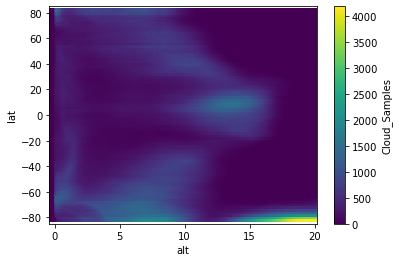

In [123]:
testds['Cloud_Samples'].mean('lon').plot()

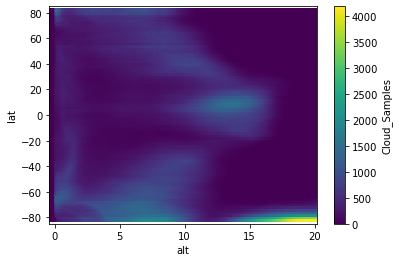

In [121]:
testds['Cloud_Samples'].mean('lon').plot()

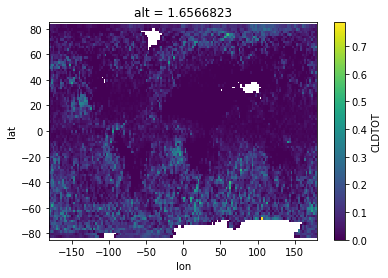

In [83]:
testds['CLDTOT'][:,:,34].plot()

In [72]:
testds.alt

<xarray.DataArray 'alt' (alt: 344)>
array([-0.380048, -0.320144, -0.26024 , ..., 20.047157, 20.107063, 20.166965],
      dtype=float32)
Coordinates:
  * alt      (alt) float32 -0.38 -0.3201 -0.2602 -0.2003 ... 20.05 20.11 20.17

In [67]:
var_dict

{'Cloud_Accepted_Samples': (('lat', 'lon', 'alt'),
  array([[[  nan,   nan,   nan, ...,   nan,   nan,   nan],
          [  nan,   nan,   nan, ...,   nan,   nan,   nan],
          [  nan,   nan,   nan, ...,   nan,   nan,   nan],
          ...,
          [  nan,   nan,   nan, ...,   nan,   nan,   nan],
          [  nan,   nan,   nan, ...,   nan,   nan,   nan],
          [  nan,   nan,   nan, ...,   nan,   nan,   nan]],
  
         [[   0.,    0.,    0., ..., 1468., 1468., 1468.],
          [   0.,    0.,    0., ..., 1542., 1542., 1542.],
          [   0.,    0.,    0., ..., 1610., 1610., 1610.],
          ...,
          [   0.,    0.,    0., ..., 1469., 1469., 1467.],
          [   0.,    0.,    0., ..., 1483., 1468., 1455.],
          [   0.,    0.,    0., ..., 1382., 1382., 1382.]],
  
         [[   0.,    0.,    0., ..., 1336., 1336., 1336.],
          [   0.,    0.,    0., ..., 1218., 1218., 1218.],
          [   0.,    0.,    0., ..., 1143., 1143., 1143.],
          ...,
          [

In [ ]:
var_dict = {}

In [65]:
testds = xr.Dataset(
    {"cloud_accpt": (('lat','lon','alt') ,data)},
    coords={
        'lat': lat,
        'lon': lon,
        'alt': alt,  
    },
)

SyntaxError: 'break' outside loop (<ipython-input-65-57283acb9061>, line 48)

In [57]:
data

array([[[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[   0.,    0.,    0., ..., 1468., 1468., 1468.],
        [   0.,    0.,    0., ..., 1542., 1542., 1542.],
        [   0.,    0.,    0., ..., 1610., 1610., 1610.],
        ...,
        [   0.,    0.,    0., ..., 1469., 1469., 1467.],
        [   0.,    0.,    0., ..., 1483., 1468., 1455.],
        [   0.,    0.,    0., ..., 1382., 1382., 1382.]],

       [[   0.,    0.,    0., ..., 1336., 1336., 1336.],
        [   0.,    0.,    0., ..., 1218., 1218., 1218.],
        [   0.,    0.,    0., ..., 1143., 1143., 1143.],
        ...,
        [   0.,    0.,    0., ..., 1424., 1424., 1424.],
        [   0.,    0.,    0., ..., 1365., 133

In [15]:
Lon,Lat = np.meshgrid(lon,lat)

In [17]:
zmean = np.mean(data,axis=2)
zsum = np.sum(data,axis=2)

In [62]:
test2 = np.mean(data,axis=1)

In [63]:
test2.shape

(85, 344)

In [ ]:
plt.plot()

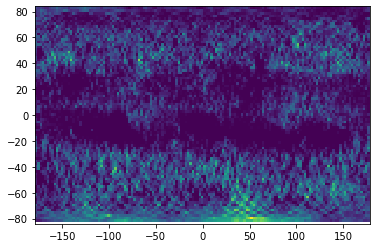

In [58]:
plt.pcolor(Lon,Lat, data[:,:,160])

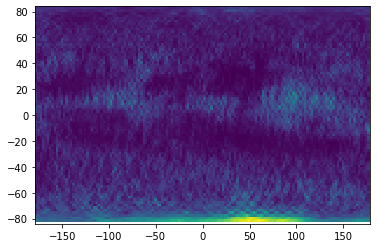

In [19]:
plt.pcolor(Lon,Lat, zsum)

In [30]:
lat

array([-84., -82., -80., -78., -76., -74., -72., -70., -68., -66., -64.,
       -62., -60., -58., -56., -54., -52., -50., -48., -46., -44., -42.,
       -40., -38., -36., -34., -32., -30., -28., -26., -24., -22., -20.,
       -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,
         4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,  24.,
        26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,
        48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,  68.,
        70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.], dtype=float32)

In [34]:
alt.shape

(344,)

In [35]:
testds = xr.Dataset(
    {"cloud_accpt": (('lat','lon','alt') ,data)},
    coords={
        'lat': lat,
        'lon': lon,
        'alt': alt,  
    },
)

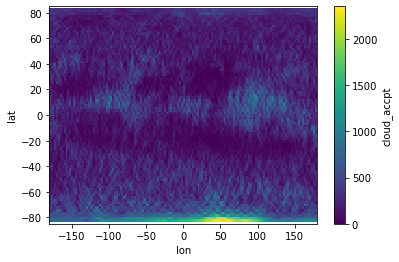

In [37]:
testds['cloud_accpt'].mean(dim='alt').plot()

In [24]:
ds = xr.Dataset(
    {"foo": (("x", "y"), np.random.rand(4, 5))},
    coords={
        "x": [10, 20, 30, 40],
        "y": pd.date_range("2000-01-01", periods=5),
        "z": ("x", list("abcd")),
    },
)

ValueError: x and y must be the same size

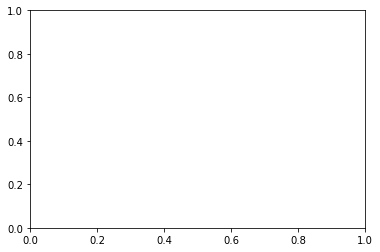

In [64]:
plt.scatter(lon, lat, c=data, s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label(units)

In [36]:
latitude[:]

array([-84., -82., -80., -78., -76., -74., -72., -70., -68., -66., -64.,
       -62., -60., -58., -56., -54., -52., -50., -48., -46., -44., -42.,
       -40., -38., -36., -34., -32., -30., -28., -26., -24., -22., -20.,
       -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,
         4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,  24.,
        26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,
        48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,  68.,
        70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.], dtype=float32)

In [32]:
np.where(invalid, np.nan, data)

array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [   0.,    0.,    0., ..., 1468., 1468., 1468.],
       [   0.,    0.,    0., ..., 1336., 1336., 1336.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]])

In [20]:
invalid

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True]])

In [45]:
invalid.shape

(85, 144, 344)

In [19]:
np.reshape(invalid,(85*344,))

array([ True,  True,  True, ...,  True,  True,  True])

In [14]:
np.where(data[invalid])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [29]:
np.where(data[invalid])[0].shape

(688,)

In [ ]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90, 91, 45))
m.drawmeridians(np.arange(-180, 180, 45), labels=[True,False,False,True])
m.scatter(lon, lat, c=data, s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label(units)

basename = os.path.basename(FILE_NAME)
# There is no long_name attribute on dataset.
longname = DATAFIELD_NAME
plt.title('{0}\n{1}'.format(basename, longname))
plt.show()

In [ ]:
"""
Copyright (C) 2018 The HDF Group

This example code illustrates how to access and visualize a LaRC CALIPSO file 
in file in Python.

If you have any questions, suggestions, or comments on this example, please use
the HDF-EOS Forum (http://hdfeos.org/forums).  If you would like to see an
example of any other NASA HDF/HDF-EOS data product that is not listed in the
HDF-EOS Comprehensive Examples page (http://hdfeos.org/zoo), feel free to
contact us at eoshelp@hdfgroup.org or post it at the HDF-EOS Forum
(http://hdfeos.org/forums).

Usage:  save this script and run

    python CAL_LID_L2_05kmAPro-Standard-V4-10.2007-03-06T09-29-19ZD.hdf.py

The HDF file must be in your current working directory.

Last Update: 2018-02-15
"""
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from pyhdf.SD import SD, SDC

DATAFIELD_NAME = 'Column_Optical_Depth_Cloud_532'
FILE_NAME = 'CAL_LID_L2_05kmAPro-Standard-V4-10.2007-03-06T09-29-19ZD.hdf'
hdf = SD(FILE_NAME, SDC.READ)
        
# Read dataset.
data2D = hdf.select(DATAFIELD_NAME)
data = data2D[:,0]

# Read attributes.
attrs = data2D.attributes(full=1)
fva=attrs["fillvalue"]
_FillValue = fva[0]
ua=attrs["units"]
units = ua[0]

vra=attrs["valid_range"]
vra_str = vra[0]

# Valid attribute is string '0.0...25.0'.
smin, smax = vra_str.split("...")
valid_min = float(smin)
valid_max = float(smax)

invalid = np.logical_or(data > valid_max,
                        data < valid_min)
invalid = np.logical_or(invalid, data == _FillValue)
data[invalid] = np.nan

# Read geolocation datasets.
latitude = hdf.select('Latitude')
lat = latitude[:,0]

longitude = hdf.select('Longitude')
lon = longitude[:,0]

m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90, 91, 45))
m.drawmeridians(np.arange(-180, 180, 45), labels=[True,False,False,True])
m.scatter(lon, lat, c=data, s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label(units)

basename = os.path.basename(FILE_NAME)
# There is no long_name attribute on dataset.
longname = DATAFIELD_NAME
plt.title('{0}\n{1}'.format(basename, longname))
plt.show()

In [ ]:
fig = plt.gcf()

pngfile = "{0}.py.png".format(basename)
fig.savefig(pngfile)